## Predator-Prey Cellular Automaton Model

Based on: Cattaneo, Dennunzio, and Farina (2006) - "A Full Cellular Automaton to Simulate Predator-Prey Systems"

This implementation extends the original model to support:
- 1 prey species
- Up to 2 predator species (user-configurable)
- Fully local cellular automaton rules (no Monte Carlo steps)
- Configurable initial populations

Rajnil Mukherjee
\
MS21213
\
Department of Physical Sciences

### The Framework

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
%matplotlib notebook

from enum import IntEnum
from dataclasses import dataclass
from typing import Tuple, List, Optional
import seaborn as sns 

from scipy.optimize import minimize
from typing import Optional
from datetime import datetime
import os

In [2]:
# ============================================================================
# CONFIGURATION AND CONSTANTS
# ============================================================================

class CellState(IntEnum):
    """
    Cell states in the automaton:
    - EMPTY: No organism
    - PREY: Contains a prey organism
    - PREDATOR1: Contains a predator of type 1
    - PREDATOR2: Contains a predator of type 2
    - EMPTY_AFTER_ATTACK: Temporary state after prey is eaten
    - PREDATOR1_FED: Temporary state for predator 1 that successfully hunted
    - PREDATOR2_FED: Temporary state for predator 2 that successfully hunted
    """
    EMPTY = 0
    PREY = 1
    PREDATOR1 = 2
    PREDATOR2 = 3
    EMPTY_AFTER_ATTACK = 4
    PREDATOR1_FED = 5
    PREDATOR2_FED = 6


@dataclass
class SpeciesParameters:
    """
    Parameters for each species in the simulation.
    
    Attributes:
        birth_prob: Probability of reproduction (0 to 1)
        death_prob: Probability of natural death (0 to 1)
        hunt_success_prob: Probability of successful hunt per prey in neighborhood
    """
    birth_prob: float
    death_prob: float
    hunt_success_prob: float = 0.0  # Only for predators


@dataclass
class SimulationConfig:
    """
    Configuration for the entire simulation.
    
    Attributes:
        grid_size: Tuple of (rows, cols) for the lattice
        num_predator_types: Number of predator types (1 or 2)
        initial_prey: Initial number of prey organisms
        initial_predator1: Initial number of predator type 1
        initial_predator2: Initial number of predator type 2
        prey_params: Parameters for prey species
        predator1_params: Parameters for predator type 1
        predator2_params: Parameters for predator type 2
        movement_radius: Radius for Moore neighborhood in movement phase
        use_enhanced_model: Whether to use the enhanced model with oscillations
    """
    grid_size: Tuple[int, int]
    num_predator_types: int
    initial_prey: int
    initial_predator1: int
    initial_predator2: int
    prey_params: SpeciesParameters
    predator1_params: SpeciesParameters
    predator2_params: SpeciesParameters
    movement_radius: int = 2
    use_enhanced_model: bool = True
    enhancement_function: str = "cosine"  # "cosine" or "exponential"


# ============================================================================
# CELLULAR AUTOMATON CLASS
# ============================================================================

class PredatorPreyCA:
    """
    Main Cellular Automaton class for predator-prey simulation.
    
    Implements the full CA model with:
    1. Reaction phase (attack and reproduction)
    2. Movement phase (fully local, no Monte Carlo)
    """
    
    def __init__(self, config: SimulationConfig):
        """
        Initialize the cellular automaton with given configuration.
        
        Args:
            config: SimulationConfig object with all parameters
        """
        self.config = config
        self.rows, self.cols = config.grid_size
        self.grid = np.zeros((self.rows, self.cols), dtype=int)
        
        # Population tracking
        self.prey_history = []
        self.predator1_history = []
        self.predator2_history = []
        self.time_step = 0
        
        # Initialize the grid with random positions
        self._initialize_populations()
        
    def _initialize_populations(self):
        """
        Randomly place initial populations on the grid.
        Ensures no overlap between organisms (exclusion principle).
        """
        total_cells = self.rows * self.cols
        total_organisms = (self.config.initial_prey + 
                          self.config.initial_predator1 + 
                          self.config.initial_predator2)
        
        if total_organisms > total_cells:
            raise ValueError("Total organisms exceed available cells!")
        
        # Get random positions without replacement
        positions = np.random.choice(total_cells, total_organisms, replace=False)
        
        # Place prey
        prey_positions = positions[:self.config.initial_prey]
        for pos in prey_positions:
            row, col = divmod(pos, self.cols)
            self.grid[row, col] = CellState.PREY
        
        # Place predator 1
        pred1_start = self.config.initial_prey
        pred1_end = pred1_start + self.config.initial_predator1
        pred1_positions = positions[pred1_start:pred1_end]
        for pos in pred1_positions:
            row, col = divmod(pos, self.cols)
            self.grid[row, col] = CellState.PREDATOR1
        
        # Place predator 2 if enabled
        if self.config.num_predator_types == 2:
            pred2_positions = positions[pred1_end:]
            for pos in pred2_positions:
                row, col = divmod(pos, self.cols)
                self.grid[row, col] = CellState.PREDATOR2
    
    # ========================================================================
    # NEIGHBORHOOD FUNCTIONS
    # ========================================================================
    
    def _get_von_neumann_neighbors(self, row: int, col: int) -> List[Tuple[int, int]]:
        """
        Get Von Neumann neighborhood (4 nearest neighbors) with periodic boundaries.
        
        Args:
            row, col: Cell coordinates
            
        Returns:
            List of (row, col) tuples for neighbors
        """
        neighbors = [
            ((row - 1) % self.rows, col),  # North
            ((row + 1) % self.rows, col),  # South
            (row, (col - 1) % self.cols),  # West
            (row, (col + 1) % self.cols),  # East
        ]
        return neighbors
    
    def _get_moore_neighborhood_quadrants(self, row: int, col: int, radius: int) \
            -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Get the four quadrants of Moore neighborhood (North, South, East, West).
        Used for determining movement direction.
        
        Args:
            row, col: Cell coordinates
            radius: Radius of Moore neighborhood
            
        Returns:
            Tuple of 4 arrays containing cell states in each quadrant
        """
        north_cells = []
        south_cells = []
        east_cells = []
        west_cells = []
        
        for i in range(1, radius + 1):
            for j in range(-i, i + 1):
                # North quadrant (above current row)
                r_north = (row - i) % self.rows
                c_north = (col + j) % self.cols
                north_cells.append(self.grid[r_north, c_north])
                
                # South quadrant (below current row)
                r_south = (row + i) % self.rows
                c_south = (col + j) % self.cols
                south_cells.append(self.grid[r_south, c_south])
                
                # East quadrant (right of current col)
                r_east = (row + j) % self.rows
                c_east = (col + i) % self.cols
                east_cells.append(self.grid[r_east, c_east])
                
                # West quadrant (left of current col)
                r_west = (row + j) % self.rows
                c_west = (col - i) % self.cols
                west_cells.append(self.grid[r_west, c_west])
        
        return (np.array(north_cells), np.array(south_cells), 
                np.array(east_cells), np.array(west_cells))
    
    def _count_neighbors(self, row: int, col: int, state: CellState, 
                        neighborhood: str = "von_neumann") -> int:
        """
        Count neighbors of a specific state in the neighborhood.
        
        Args:
            row, col: Cell coordinates
            state: CellState to count
            neighborhood: "von_neumann" or "moore"
            
        Returns:
            Count of neighbors with specified state
        """
        if neighborhood == "von_neumann":
            neighbors = self._get_von_neumann_neighbors(row, col)
            return sum(1 for r, c in neighbors if self.grid[r, c] == state)
        else:
            # Full Moore neighborhood
            count = 0
            for dr in [-1, 0, 1]:
                for dc in [-1, 0, 1]:
                    if dr == 0 and dc == 0:
                        continue
                    r = (row + dr) % self.rows
                    c = (col + dc) % self.cols
                    if self.grid[r, c] == state:
                        count += 1
            return count
    
    # ========================================================================
    # REACTION PHASE
    # ========================================================================
    
    def _attack_phase(self) -> np.ndarray:
        """
        Execute the attack sub-phase of the reaction step.
        
        Implements predator-prey interactions:
        - Prey can be killed by predators
        - Predators hunt prey based on neighborhood
        
        Returns:
            New grid state after attacks
        """
        new_grid = self.grid.copy()
        
        for row in range(self.rows):
            for col in range(self.cols):
                state = self.grid[row, col]
                
                # Process prey cells
                if state == CellState.PREY:
                    new_grid[row, col] = self._process_prey_attack(row, col)
                
                # Process predator 1 cells
                elif state == CellState.PREDATOR1:
                    new_grid[row, col] = self._process_predator_attack(
                        row, col, CellState.PREDATOR1,
                        self.config.predator1_params.hunt_success_prob
                    )
                
                # Process predator 2 cells
                elif state == CellState.PREDATOR2:
                    new_grid[row, col] = self._process_predator_attack(
                        row, col, CellState.PREDATOR2,
                        self.config.predator2_params.hunt_success_prob
                    )
        
        return new_grid
    
    def _process_prey_attack(self, row: int, col: int) -> CellState:
        """
        Process a prey cell during attack phase.
        
        Args:
            row, col: Prey cell coordinates
            
        Returns:
            New state for the cell
        """
        # Count predators in Von Neumann neighborhood
        num_pred1 = self._count_neighbors(row, col, CellState.PREDATOR1)
        num_pred2 = self._count_neighbors(row, col, CellState.PREDATOR2)
        total_predators = num_pred1 + num_pred2
        
        if total_predators == 0:
            # Enhanced model: check for overcrowding
            if self.config.use_enhanced_model:
                return self._process_prey_overcrowding(row, col)
            return CellState.PREY
        
        # Prey survival probability decreases with more predators
        survival_prob = (1 - self.config.predator1_params.hunt_success_prob) ** num_pred1
        survival_prob *= (1 - self.config.predator2_params.hunt_success_prob) ** num_pred2
        
        if np.random.random() < survival_prob:
            return CellState.PREY
        else:
            return CellState.EMPTY_AFTER_ATTACK
    
    def _process_prey_overcrowding(self, row: int, col: int) -> CellState:
        """
        Enhanced model: prey can die from overcrowding when no predators present.
        This helps create oscillatory dynamics similar to logistic equation.
        
        Args:
            row, col: Prey cell coordinates
            
        Returns:
            New state for the cell
        """
        # Count prey in Moore neighborhood of radius r
        radius = self.config.movement_radius
        total_prey = 0
        total_cells = (2 * radius + 1) ** 2
        
        for dr in range(-radius, radius + 1):
            for dc in range(-radius, radius + 1):
                r = (row + dr) % self.rows
                c = (col + dc) % self.cols
                if self.grid[r, c] == CellState.PREY:
                    total_prey += 1
        
        # Apply enhancement function
        bp = self.config.prey_params.birth_prob
        
        if self.config.enhancement_function == "cosine":
            f_bp = 1 - np.cos(np.pi / 2 * bp)
        else:  # exponential
            f_bp = 1 - np.exp(-np.e * bp)
        
        # Death probability increases with prey density
        death_prob = total_prey * f_bp / total_cells
        
        if np.random.random() < death_prob:
            return CellState.EMPTY_AFTER_ATTACK
        
        return CellState.PREY
    
    def _process_predator_attack(self, row: int, col: int, 
                                 predator_type: CellState,
                                 hunt_prob: float) -> CellState:
        """
        Process a predator cell during attack phase.
        
        Args:
            row, col: Predator cell coordinates
            predator_type: Type of predator (PREDATOR1 or PREDATOR2)
            hunt_prob: Hunting success probability
            
        Returns:
            New state for the cell
        """
        # Count prey in Von Neumann neighborhood
        num_prey = self._count_neighbors(row, col, CellState.PREY)
        
        if num_prey == 0:
            return predator_type
        
        # Hunt success probability increases with more prey
        hunt_success_prob = 1 - (1 - hunt_prob) ** num_prey
        
        if np.random.random() < hunt_success_prob:
            # Successfully hunted - mark as fed
            if predator_type == CellState.PREDATOR1:
                return CellState.PREDATOR1_FED
            else:
                return CellState.PREDATOR2_FED
        
        return predator_type
    
    def _reproduction_phase(self, grid: np.ndarray) -> np.ndarray:
        """
        Execute the reproduction sub-phase of the reaction step.
        
        Handles:
        - Prey reproduction in empty cells
        - Predator reproduction after successful hunt
        - Natural death of predators
        
        Args:
            grid: Grid state after attack phase
            
        Returns:
            New grid state after reproduction
        """
        new_grid = grid.copy()
        
        for row in range(self.rows):
            for col in range(self.cols):
                state = grid[row, col]
                
                # Prey cells remain prey
                if state == CellState.PREY:
                    new_grid[row, col] = CellState.PREY
                
                # Predator 1 cells
                elif state in [CellState.PREDATOR1, CellState.PREDATOR1_FED]:
                    new_grid[row, col] = self._process_predator_reproduction(
                        row, col, CellState.PREDATOR1,
                        self.config.predator1_params.death_prob
                    )
                
                # Predator 2 cells
                elif state in [CellState.PREDATOR2, CellState.PREDATOR2_FED]:
                    new_grid[row, col] = self._process_predator_reproduction(
                        row, col, CellState.PREDATOR2,
                        self.config.predator2_params.death_prob
                    )
                
                # Empty cells and cells emptied by attack
                elif state in [CellState.EMPTY, CellState.EMPTY_AFTER_ATTACK]:
                    new_grid[row, col] = self._process_empty_cell(row, col, grid)
        
        return new_grid
    
    def _process_predator_reproduction(self, row: int, col: int,
                                      predator_type: CellState,
                                      death_prob: float) -> CellState:
        """
        Process predator reproduction and death.
        
        Args:
            row, col: Cell coordinates
            predator_type: Type of predator
            death_prob: Natural death probability
            
        Returns:
            New state for the cell
        """
        # Predator can die naturally
        if np.random.random() < death_prob:
            return CellState.EMPTY
        
        return predator_type
    
    def _process_empty_cell(self, row: int, col: int, grid: np.ndarray) -> CellState:
        """
        Process empty cell for potential reproduction.
        
        Args:
            row, col: Cell coordinates
            grid: Current grid state
            
        Returns:
            New state for the cell
        """
        state = grid[row, col]
        neighbors = self._get_von_neumann_neighbors(row, col)
        
        # Count different types of neighbors
        num_prey = sum(1 for r, c in neighbors if grid[r, c] == CellState.PREY)
        num_pred1 = sum(1 for r, c in neighbors 
                       if grid[r, c] in [CellState.PREDATOR1, CellState.PREDATOR1_FED])
        num_pred2 = sum(1 for r, c in neighbors 
                       if grid[r, c] in [CellState.PREDATOR2, CellState.PREDATOR2_FED])
        
        # If cell was emptied by attack (prey was eaten)
        if state == CellState.EMPTY_AFTER_ATTACK:
            # Count fed predators in neighborhood
            num_fed_pred1 = sum(1 for r, c in neighbors 
                              if grid[r, c] == CellState.PREDATOR1_FED)
            num_fed_pred2 = sum(1 for r, c in neighbors 
                              if grid[r, c] == CellState.PREDATOR2_FED)
            total_fed = num_fed_pred1 + num_fed_pred2
            
            if total_fed == 0:
                return CellState.EMPTY
            
            # Predator reproduction based on successful hunts
            # Predator 1 has priority if both types fed
            if num_fed_pred1 > 0:
                birth_prob = self.config.predator1_params.birth_prob
                if np.random.random() > (1 - birth_prob) ** num_fed_pred1:
                    return CellState.PREDATOR1
            
            if num_fed_pred2 > 0:
                birth_prob = self.config.predator2_params.birth_prob
                if np.random.random() > (1 - birth_prob) ** num_fed_pred2:
                    return CellState.PREDATOR2
            
            return CellState.EMPTY
        
        # Regular empty cell - can have prey reproduction
        if num_pred1 + num_pred2 > 0 or num_prey == 0:
            return CellState.EMPTY
        
        # Prey reproduction
        birth_prob = self.config.prey_params.birth_prob
        if np.random.random() > (1 - birth_prob) ** num_prey:
            return CellState.PREY
        
        return CellState.EMPTY
    
    # ========================================================================
    # MOVEMENT PHASE
    # ========================================================================
    
    def _movement_phase(self, grid: np.ndarray) -> np.ndarray:
        """
        Execute the movement phase - fully local, no Monte Carlo.
        
        Movement rules:
        - Prey move away from predators
        - Predators move toward prey
        - Movement is to adjacent Von Neumann neighbors only
        
        Args:
            grid: Grid state after reaction phase
            
        Returns:
            New grid state after movement
        """
        # Normalize fed predator states
        normalized_grid = grid.copy()
        normalized_grid[grid == CellState.PREDATOR1_FED] = CellState.PREDATOR1
        normalized_grid[grid == CellState.PREDATOR2_FED] = CellState.PREDATOR2
        normalized_grid[grid == CellState.EMPTY_AFTER_ATTACK] = CellState.EMPTY
        
        # Calculate movement intentions for all cells
        movement_intentions = {}
        
        for row in range(self.rows):
            for col in range(self.cols):
                state = normalized_grid[row, col]
                
                if state == CellState.EMPTY:
                    continue
                
                # Determine preferred direction
                direction = self._get_preferred_direction(row, col, state, normalized_grid)
                
                if direction is not None:
                    movement_intentions[(row, col)] = direction
        
        # Execute movements (resolve conflicts)
        new_grid = self._execute_movements(normalized_grid, movement_intentions)
        
        return new_grid
    
    def _get_preferred_direction(self, row: int, col: int, 
                                 state: CellState, grid: np.ndarray) -> Optional[Tuple[int, int]]:
        """
        Determine preferred movement direction for an organism.
        
        Args:
            row, col: Cell coordinates
            state: Current cell state
            grid: Current grid
            
        Returns:
            Target (row, col) or None if no movement
        """
        radius = self.config.movement_radius
        
        # Get quadrant counts
        north, south, east, west = self._get_moore_neighborhood_quadrants(row, col, radius)
        
        if state == CellState.PREY:
            # Prey moves away from predators
            pred_counts = {
                'north': np.sum((north == CellState.PREDATOR1) | (north == CellState.PREDATOR2)),
                'south': np.sum((south == CellState.PREDATOR1) | (south == CellState.PREDATOR2)),
                'east': np.sum((east == CellState.PREDATOR1) | (east == CellState.PREDATOR2)),
                'west': np.sum((west == CellState.PREDATOR1) | (west == CellState.PREDATOR2)),
            }
            
            # No predators nearby - no movement
            if sum(pred_counts.values()) == 0:
                return None
            
            # Move to quadrant with fewest predators
            min_pred = min(pred_counts.values())
            candidates = [d for d, c in pred_counts.items() if c == min_pred]
            
        else:  # Predator
            # Predators move toward prey
            prey_counts = {
                'north': np.sum(north == CellState.PREY),
                'south': np.sum(south == CellState.PREY),
                'east': np.sum(east == CellState.PREY),
                'west': np.sum(west == CellState.PREY),
            }
            
            # No prey nearby - no movement
            if sum(prey_counts.values()) == 0:
                return None
            
            # Move to quadrant with most prey
            max_prey = max(prey_counts.values())
            candidates = [d for d, c in prey_counts.items() if c == max_prey]
        
        # Choose random direction among candidates
        chosen_direction = np.random.choice(candidates)
        
        # Map direction to actual neighbor cell
        direction_map = {
            'north': ((row - 1) % self.rows, col),
            'south': ((row + 1) % self.rows, col),
            'east': (row, (col + 1) % self.cols),
            'west': (row, (col - 1) % self.cols),
        }
        
        return direction_map[chosen_direction]
    
    def _execute_movements(self, grid: np.ndarray, 
                          intentions: dict) -> np.ndarray:
        """
        Execute all movements, resolving conflicts.
        
        If multiple organisms want to move to the same cell,
        one is chosen randomly.
        
        Args:
            grid: Current grid state
            intentions: Dictionary mapping (row, col) -> target (row, col)
            
        Returns:
            New grid after movements
        """
        new_grid = np.zeros_like(grid)
        
        # Group intentions by target cell
        target_to_sources = {}
        for source, target in intentions.items():
            # Only move to empty cells
            if grid[target] == CellState.EMPTY:
                if target not in target_to_sources:
                    target_to_sources[target] = []
                target_to_sources[target].append(source)
        
        # Track which cells have moved
        moved = set()
        
        # Resolve movements
        for target, sources in target_to_sources.items():
            # Choose random organism if multiple want same cell
            chosen_source = sources[np.random.randint(len(sources))]
            new_grid[target] = grid[chosen_source]
            moved.add(chosen_source)
        
        # Copy non-moving organisms
        for row in range(self.rows):
            for col in range(self.cols):
                if (row, col) not in moved and grid[row, col] != CellState.EMPTY:
                    if new_grid[row, col] == CellState.EMPTY:  # Cell not already occupied
                        new_grid[row, col] = grid[row, col]
        
        return new_grid
    
    # ========================================================================
    # SIMULATION CONTROL
    # ========================================================================
    
    def step(self):
        """
        Execute one complete time step of the CA.
        
        Consists of:
        1. Attack phase
        2. Reproduction phase
        3. Movement phase
        """
        # Reaction phase
        grid_after_attack = self._attack_phase()
        grid_after_reproduction = self._reproduction_phase(grid_after_attack)
        
        # Movement phase
        self.grid = self._movement_phase(grid_after_reproduction)
        
        # Update statistics
        self._update_statistics()
        self.time_step += 1
    
    def _update_statistics(self):
        """
        Update population statistics for current time step.
        """
        prey_count = np.sum(self.grid == CellState.PREY)
        pred1_count = np.sum(self.grid == CellState.PREDATOR1)
        pred2_count = np.sum(self.grid == CellState.PREDATOR2)
        
        self.prey_history.append(prey_count)
        self.predator1_history.append(pred1_count)
        self.predator2_history.append(pred2_count)
    
    def run(self, num_steps: int, verbose: bool = True):
        """
        Run the simulation for a specified number of steps.
        
        Args:
            num_steps: Number of time steps to simulate
            verbose: Whether to print progress
        """
        for step in range(num_steps):
            self.step()
            
            if verbose and (step + 1) % 10 == 0:
                print(f"Step {step + 1}/{num_steps}: "
                      f"Prey={self.prey_history[-1]}, "
                      f"Pred1={self.predator1_history[-1]}, "
                      f"Pred2={self.predator2_history[-1]}")
    
    def get_population_stats(self) -> dict:
        """
        Get current population statistics.
        
        Returns:
            Dictionary with population counts
        """
        return {
            'prey': self.prey_history[-1] if self.prey_history else 0,
            'predator1': self.predator1_history[-1] if self.predator1_history else 0,
            'predator2': self.predator2_history[-1] if self.predator2_history else 0,
            'time_step': self.time_step
        }
    



### Visualisation Functions

In [14]:
"""
Enhanced Visualization Module for Predator-Prey Cellular Automaton
Includes live animation with GIF export capability
"""

# ============================================================================
# ENHANCED VISUALIZATION FUNCTIONS
# ============================================================================

def create_live_animation_with_gif(ca: PredatorPreyCA, 
                                   num_frames: int = 300,
                                   interval: int = 50,
                                   save_gif: bool = True,
                                   gif_filename: Optional[str] = None,
                                   dpi: int = 100) -> FuncAnimation:
    """
    Create a comprehensive live animation of the CA evolution and save as GIF.
    
    Shows:
    1. Spatial grid evolution (left panel)
    2. Population time series (top right)
    3. Phase space trajectory (bottom right)
    
    Args:
        ca: PredatorPreyCA instance (will be reset)
        num_frames: Number of frames in animation
        interval: Milliseconds between frames
        save_gif: Whether to save animation as GIF
        gif_filename: Custom filename for GIF (auto-generated if None)
        dpi: Resolution of the animation
        
    Returns:
        FuncAnimation object
    """
    print("\n" + "="*70)
    print("CREATING LIVE ANIMATION")
    print("="*70)
    
    # Reset CA to initial state
    initial_config = ca.config
    ca.__init__(initial_config)
    
    # Create output directory if saving
    if save_gif:
        os.makedirs("output", exist_ok=True)
        if gif_filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            gif_filename = f"output/predator_prey_animation_{timestamp}.gif"
        print(f"Animation will be saved to: {gif_filename}")
    
    # Setup figure with custom layout
    fig = plt.figure(figsize=(18, 9))
    gs = GridSpec(2, 2, figure=fig, width_ratios=[1.2, 1], height_ratios=[1, 1],
                  hspace=0.3, wspace=0.3)
    
    # Create subplots
    ax_grid = fig.add_subplot(gs[:, 0])  # Left: full height for grid
    ax_timeseries = fig.add_subplot(gs[0, 1])  # Top right: time series
    ax_phase = fig.add_subplot(gs[1, 1])  # Bottom right: phase space
    
    # ========================================================================
    # GRID VISUALIZATION SETUP
    # ========================================================================
    
    # Enhanced color map
    colors = ['#F0F0F0',  # Empty - light gray
              '#2ECC71',  # Prey - green
              '#E74C3C',  # Predator 1 - red
              '#F39C12']  # Predator 2 - orange
    
    cmap = plt.cm.colors.ListedColormap(colors)
    bounds = [0, 1, 2, 3, 4]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    # Initial grid display
    display_grid = _prepare_display_grid(ca.grid)
    im = ax_grid.imshow(display_grid, cmap=cmap, norm=norm, 
                       interpolation='nearest', aspect='equal')
    
    # Grid styling
    ax_grid.set_title('Spatial Distribution', fontsize=14, fontweight='bold', pad=10)
    ax_grid.set_xlabel('X Position', fontsize=11)
    ax_grid.set_ylabel('Y Position', fontsize=11)
    
    # Add custom legend
    legend_elements = [
        mpatches.Patch(facecolor=colors[0], edgecolor='black', label='Empty'),
        mpatches.Patch(facecolor=colors[1], edgecolor='black', label='Prey'),
        mpatches.Patch(facecolor=colors[2], edgecolor='black', label='Predator 1')
    ]
    if ca.config.num_predator_types == 2:
        legend_elements.append(
            mpatches.Patch(facecolor=colors[3], edgecolor='black', label='Predator 2')
        )
    
    ax_grid.legend(handles=legend_elements, loc='upper left', 
                  bbox_to_anchor=(0, -0.05), ncol=4, frameon=True, fontsize=10)
    
    # Add info text box
    info_text = ax_grid.text(0.02, 0.98, '', transform=ax_grid.transAxes,
                            fontsize=10, verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # ========================================================================
    # TIME SERIES SETUP
    # ========================================================================
    
    line_prey, = ax_timeseries.plot([], [], 'o-', color='#2ECC71', 
                                    label='Prey', linewidth=2, markersize=3)
    line_pred1, = ax_timeseries.plot([], [], 's-', color='#E74C3C', 
                                     label='Predator 1', linewidth=2, markersize=3)
    line_pred2, = ax_timeseries.plot([], [], '^-', color='#F39C12', 
                                     label='Predator 2', linewidth=2, markersize=3)
    
    ax_timeseries.set_xlabel('Time Step', fontsize=11, fontweight='bold')
    ax_timeseries.set_ylabel('Population', fontsize=11, fontweight='bold')
    ax_timeseries.set_title('Population Dynamics', fontsize=14, fontweight='bold')
    ax_timeseries.legend(loc='best', fontsize=10, framealpha=0.9)
    ax_timeseries.grid(True, alpha=0.3, linestyle='--')
    
    # ========================================================================
    # PHASE SPACE SETUP
    # ========================================================================
    
    phase_line, = ax_phase.plot([], [], '-', color='#3498DB', 
                                linewidth=1.5, alpha=0.6)
    phase_start = ax_phase.scatter([], [], c='green', s=150, 
                                   marker='o', label='Start', 
                                   zorder=5, edgecolors='black', linewidths=2)
    phase_current = ax_phase.scatter([], [], c='red', s=150, 
                                     marker='*', label='Current', 
                                     zorder=6, edgecolors='black', linewidths=2)
    
    ax_phase.set_xlabel('Prey Population', fontsize=11, fontweight='bold')
    ax_phase.set_ylabel('Predator 1 Population', fontsize=11, fontweight='bold')
    ax_phase.set_title('Phase Space (Prey vs Predator 1)', 
                      fontsize=14, fontweight='bold')
    ax_phase.legend(loc='best', fontsize=10, framealpha=0.9)
    ax_phase.grid(True, alpha=0.3, linestyle='--')
    
    # ========================================================================
    # ANIMATION FUNCTIONS
    # ========================================================================
    
    def init():
        """Initialize animation."""
        # Set axis limits
        max_pop = max(ca.config.initial_prey, 
                     ca.config.initial_predator1,
                     ca.config.initial_predator2) * 1.5
        
        ax_timeseries.set_xlim(0, num_frames)
        ax_timeseries.set_ylim(0, max_pop)
        
        ax_phase.set_xlim(0, max_pop)
        ax_phase.set_ylim(0, max_pop)
        
        return (im, line_prey, line_pred1, line_pred2, 
                phase_line, phase_start, phase_current, info_text)
    
    def update(frame):
        """Update animation for each frame."""
        # Perform CA step (skip for first frame)
        if frame > 0:
            ca.step()
        
        # Update grid visualization
        display_grid = _prepare_display_grid(ca.grid)
        im.set_array(display_grid)
        
        # Update info text
        prey_count = ca.prey_history[-1] if ca.prey_history else 0
        pred1_count = ca.predator1_history[-1] if ca.predator1_history else 0
        pred2_count = ca.predator2_history[-1] if ca.predator2_history else 0
        
        info_str = (f'Step: {ca.time_step}\n'
                   f'Prey: {prey_count}\n'
                   f'Pred1: {pred1_count}')
        if ca.config.num_predator_types == 2:
            info_str += f'\nPred2: {pred2_count}'
        
        info_text.set_text(info_str)
        
        # Update time series
        time_steps = list(range(len(ca.prey_history)))
        line_prey.set_data(time_steps, ca.prey_history)
        line_pred1.set_data(time_steps, ca.predator1_history)
        if ca.config.num_predator_types == 2:
            line_pred2.set_data(time_steps, ca.predator2_history)
        
        # Auto-scale y-axis for time series if needed
        if ca.prey_history:
            max_current = max(max(ca.prey_history), 
                            max(ca.predator1_history))
            if ca.config.num_predator_types == 2:
                max_current = max(max_current, max(ca.predator2_history))
            
            current_ylim = ax_timeseries.get_ylim()[1]
            if max_current > current_ylim * 0.9:
                ax_timeseries.set_ylim(0, max_current * 1.2)
        
        # Update phase space
        if len(ca.prey_history) > 0:
            phase_line.set_data(ca.prey_history, ca.predator1_history)
            
            # Update start marker (only once)
            if frame == 0:
                phase_start.set_offsets([[ca.prey_history[0], 
                                        ca.predator1_history[0]]])
            
            # Update current position marker
            phase_current.set_offsets([[ca.prey_history[-1], 
                                      ca.predator1_history[-1]]])
            
            # Auto-scale phase space if needed
            max_prey = max(ca.prey_history)
            max_pred1 = max(ca.predator1_history)
            
            if max_prey > ax_phase.get_xlim()[1] * 0.9:
                ax_phase.set_xlim(0, max_prey * 1.2)
            if max_pred1 > ax_phase.get_ylim()[1] * 0.9:
                ax_phase.set_ylim(0, max_pred1 * 1.2)
        
        # Progress indicator
        if frame % 10 == 0:
            print(f"Frame {frame}/{num_frames} - "
                  f"Prey: {prey_count}, Pred1: {pred1_count}, Pred2: {pred2_count}")
        
        return (im, line_prey, line_pred1, line_pred2, 
                phase_line, phase_start, phase_current, info_text)
    
    # ========================================================================
    # CREATE ANIMATION
    # ========================================================================
    
    print(f"Generating {num_frames} frames...")
    
    anim = FuncAnimation(fig, update, frames=num_frames, 
                        init_func=init, interval=interval,
                        blit=True, repeat=True)
    
    # Save as GIF
    if save_gif:
        print(f"\nSaving animation as GIF (this may take a while)...")
        writer = PillowWriter(fps=1000//interval)
        anim.save(gif_filename, writer=writer, dpi=dpi)
        print(f"✓ Animation saved successfully to: {gif_filename}")
        
        # Get file size
        file_size = os.path.getsize(gif_filename) / (1024 * 1024)  # Convert to MB
        print(f"  File size: {file_size:.2f} MB")
    
    # Adjust layout
    plt.suptitle('Predator-Prey Cellular Automaton Evolution', 
                fontsize=16, fontweight='bold', y=0.98)
    

    
    return anim


def _prepare_display_grid(grid: np.ndarray) -> np.ndarray:
    """
    Prepare grid for display by mapping all states to display values.
    
    Args:
        grid: Raw CA grid
        
    Returns:
        Grid with states mapped to [0, 1, 2, 3]
    """
    display_grid = grid.copy()
    
    # Map predator 2 to display value 3
    display_grid[grid == CellState.PREDATOR2] = 3
    
    # Map temporary states back to their base states
    display_grid[grid == CellState.EMPTY_AFTER_ATTACK] = 0
    display_grid[grid == CellState.PREDATOR1_FED] = 2
    display_grid[grid == CellState.PREDATOR2_FED] = 3
    
    return display_grid


def create_snapshot_sequence(ca: PredatorPreyCA,
                            num_snapshots: int = 6,
                            steps_between: int = 50,
                            save_path: Optional[str] = None):
    """
    Create a sequence of snapshots showing evolution at different time points.
    
    Args:
        ca: PredatorPreyCA instance (will be reset)
        num_snapshots: Number of snapshots to take
        steps_between: Steps between each snapshot
        save_path: Path to save the figure
    """
    # Reset CA
    initial_config = ca.config
    ca.__init__(initial_config)
    
    # Setup figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Color map
    colors = ['#F0F0F0', '#2ECC71', '#E74C3C', '#F39C12']
    cmap = plt.cm.colors.ListedColormap(colors)
    bounds = [0, 1, 2, 3, 4]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    for idx in range(num_snapshots):
        # Take snapshot
        display_grid = _prepare_display_grid(ca.grid)
        
        axes[idx].imshow(display_grid, cmap=cmap, norm=norm, interpolation='nearest')
        axes[idx].set_title(f'Time Step {ca.time_step}\n'
                          f'Prey: {ca.prey_history[-1] if ca.prey_history else 0}, '
                          f'Pred1: {ca.predator1_history[-1] if ca.predator1_history else 0}',
                          fontsize=11, fontweight='bold')
        axes[idx].axis('off')
        
        # Run steps for next snapshot
        if idx < num_snapshots - 1:
            for _ in range(steps_between):
                ca.step()
    
    plt.suptitle('Evolution Sequence', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Snapshot sequence saved to: {save_path}")
    
    plt.show()


def create_comparison_gif(configs: list, 
                         num_frames: int = 200,
                         interval: int = 50,
                         gif_filename: Optional[str] = None,
                         dpi: int = 80):
    """
    Create a comparison GIF showing multiple configurations side by side.
    
    Args:
        configs: List of SimulationConfig objects to compare
        num_frames: Number of frames
        interval: Milliseconds between frames
        gif_filename: Output filename
        dpi: Resolution
    """
    num_configs = len(configs)
    
    if gif_filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        gif_filename = f"output/comparison_{timestamp}.gif"
    
    os.makedirs("output", exist_ok=True)
    
    # Create CAs
    cas = [PredatorPreyCA(config) for config in configs]
    
    # Setup figure
    fig, axes = plt.subplots(1, num_configs, figsize=(6*num_configs, 6))
    if num_configs == 1:
        axes = [axes]
    
    # Color map
    colors = ['#F0F0F0', '#2ECC71', '#E74C3C', '#F39C12']
    cmap = plt.cm.colors.ListedColormap(colors)
    bounds = [0, 1, 2, 3, 4]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    # Initialize images
    images = []
    info_texts = []
    
    for idx, (ax, ca) in enumerate(zip(axes, cas)):
        display_grid = _prepare_display_grid(ca.grid)
        im = ax.imshow(display_grid, cmap=cmap, norm=norm, interpolation='nearest')
        images.append(im)
        
        ax.set_title(f'Configuration {idx+1}', fontsize=12, fontweight='bold')
        ax.axis('off')
        
        info_text = ax.text(0.02, 0.98, '', transform=ax.transAxes,
                          fontsize=9, verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        info_texts.append(info_text)
    
    def init():
        return images + info_texts
    
    def update(frame):
        if frame > 0:
            for ca in cas:
                ca.step()
        
        for idx, (ca, im, info_text) in enumerate(zip(cas, images, info_texts)):
            display_grid = _prepare_display_grid(ca.grid)
            im.set_array(display_grid)
            
            prey = ca.prey_history[-1] if ca.prey_history else 0
            pred1 = ca.predator1_history[-1] if ca.predator1_history else 0
            
            info_text.set_text(f'Step: {ca.time_step}\nPrey: {prey}\nPred1: {pred1}')
        
        if frame % 10 == 0:
            print(f"Frame {frame}/{num_frames}")
        
        return images + info_texts
    
    print(f"Creating comparison GIF with {num_configs} configurations...")
    
    anim = FuncAnimation(fig, update, frames=num_frames, 
                        init_func=init, interval=interval, blit=True)
    
    writer = PillowWriter(fps=1000//interval)
    anim.save(gif_filename, writer=writer, dpi=dpi)
    
    plt.close()
    
    file_size = os.path.getsize(gif_filename) / (1024 * 1024)
    print(f"✓ Comparison GIF saved to: {gif_filename}")
    print(f"  File size: {file_size:.2f} MB")
    
    return anim


# ============================================================================
# UPDATED MAIN FUNCTION WITH ENHANCED VISUALIZATION
# ============================================================================

def run_simulation():
    """
    Run a simulation with enhanced visualization options.
    """
    print("=" * 70)
    print("PREDATOR-PREY CELLULAR AUTOMATON SIMULATION")
    print("Based on Cattaneo, Dennunzio, and Farina (2006)")
    print("=" * 70)
    
    # Get user configuration
    print("\n--- SIMULATION CONFIGURATION ---")
    
    grid_size = int(input("Grid size (e.g., 100 for 100x100) [default=100]: ") or "100")
    
    num_predators = int(input("Number of predator types (1 or 2) [default=2]: ") or "2")
    
    if num_predators not in [1, 2]:
        print("Invalid input. Using 2 predator types.")
        num_predators = 2
    
    initial_prey = int(input(f"Initial prey population [default={grid_size**2 // 4}]: ") 
                      or str(grid_size**2 // 4))
    initial_pred1 = int(input(f"Initial predator 1 population [default={grid_size**2 // 10}]: ") 
                       or str(grid_size**2 // 10))
    
    if num_predators == 2:
        initial_pred2 = int(input(f"Initial predator 2 population [default={grid_size**2 // 20}]: ") 
                           or str(grid_size**2 // 20))
    else:
        initial_pred2 = 0
    
    num_steps = int(input("Number of simulation steps [default=200]: ") or "200")
    
    # Animation options
    print("\n--- ANIMATION OPTIONS ---")

    gif_frames = num_steps
    gif_interval = 50
    
    gif_frames = int(input(f"Number of frames for GIF [default={num_steps}]: ") 
                    or str(num_steps))
    gif_interval = int(input("Interval between frames in ms [default=50]: ") or "50")

    
    # Create configuration
    config = SimulationConfig(
        grid_size=(grid_size, grid_size),
        num_predator_types=num_predators,
        initial_prey=initial_prey,
        initial_predator1=initial_pred1,
        initial_predator2=initial_pred2,
        prey_params=SpeciesParameters(
            birth_prob=0.6,
            death_prob=0.7
        ),
        predator1_params=SpeciesParameters(
            birth_prob=0.6,
            death_prob=0.4,
            hunt_success_prob=0.9
        ),
        predator2_params=SpeciesParameters(
            birth_prob=0.4,
            death_prob=0.3,
            hunt_success_prob=0.7
        ),
        movement_radius=2,
        use_enhanced_model=True,
        enhancement_function="cosine"
    )
    
    # Create CA
    ca = PredatorPreyCA(config)
    

    create_live_animation_with_gif(
        ca, 
        num_frames=gif_frames,
        interval=gif_interval,
        save_gif=True,
        dpi=100
    )

    
    # Display final statistics
    print("\n--- FINAL STATISTICS ---")
    stats = ca.get_population_stats()
    print(f"Prey: {stats['prey']}")
    print(f"Predator 1: {stats['predator1']}")
    if num_predators == 2:
        print(f"Predator 2: {stats['predator2']}")
    

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    create_snapshot_sequence(ca, num_snapshots=6, steps_between=50,
                            save_path=f"output/snapshots_{timestamp}.png")

    return ca


if __name__ == "__main__":
    # Run example simulation
    ca = run_simulation()
    
    print("\n" + "="*70)
    print("SIMULATION COMPLETE")
    print("="*70)

PREDATOR-PREY CELLULAR AUTOMATON SIMULATION
Based on Cattaneo, Dennunzio, and Farina (2006)

--- SIMULATION CONFIGURATION ---

--- ANIMATION OPTIONS ---

CREATING LIVE ANIMATION
Animation will be saved to: output/predator_prey_animation_20260218_193621.gif


<IPython.core.display.Javascript object>

Generating 200 frames...

Saving animation as GIF (this may take a while)...
Frame 0/200 - Prey: 0, Pred1: 0, Pred2: 0
Frame 10/200 - Prey: 1684, Pred1: 271, Pred2: 984
Frame 20/200 - Prey: 12363, Pred1: 326, Pred2: 200
Frame 30/200 - Prey: 25107, Pred1: 799, Pred2: 219
Frame 40/200 - Prey: 32084, Pred1: 1707, Pred2: 150
Frame 50/200 - Prey: 32407, Pred1: 2922, Pred2: 150
Frame 60/200 - Prey: 30257, Pred1: 3923, Pred2: 129
Frame 70/200 - Prey: 28166, Pred1: 4708, Pred2: 75
Frame 80/200 - Prey: 25956, Pred1: 5222, Pred2: 61
Frame 90/200 - Prey: 24494, Pred1: 5655, Pred2: 39
Frame 100/200 - Prey: 23472, Pred1: 5879, Pred2: 14
Frame 110/200 - Prey: 23440, Pred1: 5971, Pred2: 5
Frame 120/200 - Prey: 23244, Pred1: 6020, Pred2: 2
Frame 130/200 - Prey: 23066, Pred1: 5930, Pred2: 0
Frame 140/200 - Prey: 22934, Pred1: 5976, Pred2: 0
Frame 150/200 - Prey: 22938, Pred1: 6102, Pred2: 0
Frame 160/200 - Prey: 23238, Pred1: 5931, Pred2: 0
Frame 170/200 - Prey: 23305, Pred1: 5979, Pred2: 0
Frame 180/2

<IPython.core.display.Javascript object>

Snapshot sequence saved to: output/snapshots_20260218_200126.png

SIMULATION COMPLETE


PREDATOR-PREY CA WITH LOTKA-VOLTERRA COMPARISON
Based on Cattaneo, Dennunzio, and Farina (2006)



DEMONSTRATING LOGISTIC EQUATION BEHAVIORS


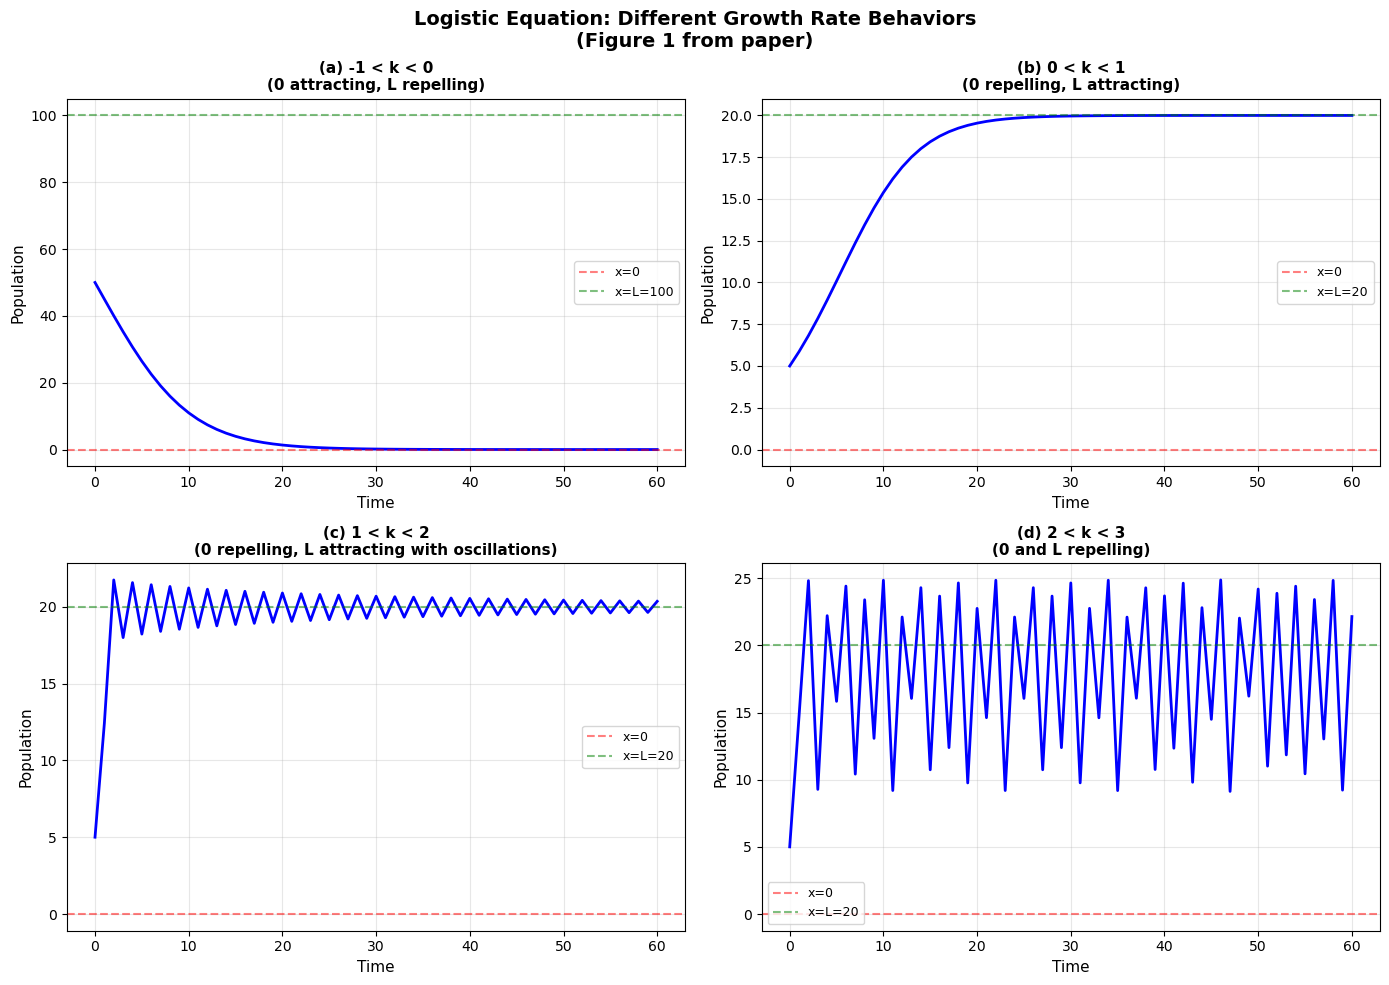


DEMONSTRATING LOTKA-VOLTERRA OSCILLATIONS


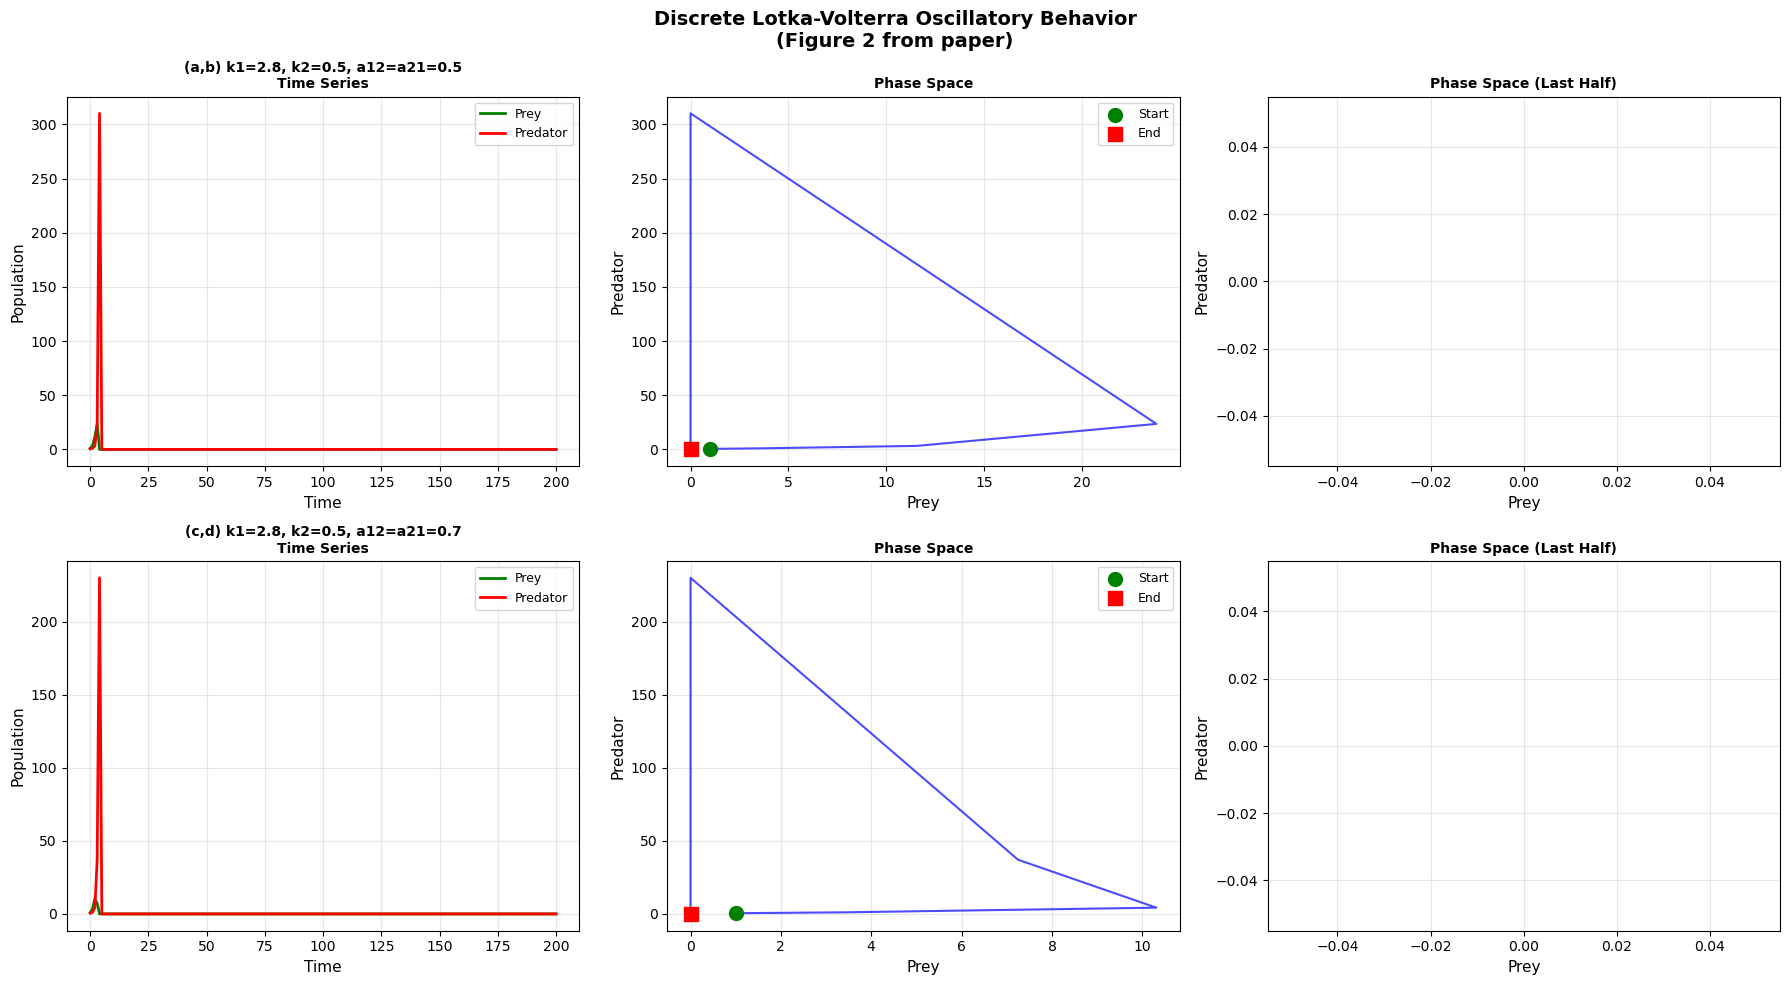


--- SIMULATION CONFIGURATION ---

--- LOTKA-VOLTERRA CALIBRATION METHOD ---
1. Manual (heuristic parameter mapping)
2. Optimize (fit to CA trajectory)
3. Paper (use parameters from Figure 2)

COMPARING CA WITH LOTKA-VOLTERRA EQUATIONS
Calibration method: paper

Running Cellular Automaton simulation...

USING PARAMETERS FROM PAPER (Figure 2)

Paper Parameters:
  k1 (prey growth): 2.800
  k2 (predator growth): 0.500
  a11 (prey competition): 0.0100
  a22 (predator competition): 0.0100
  a12 (predation rate): 0.500
  a21 (conversion efficiency): 0.500

Running Lotka-Volterra model...

✓ Comparison plot saved to: output/ca_vs_lv_paper.png


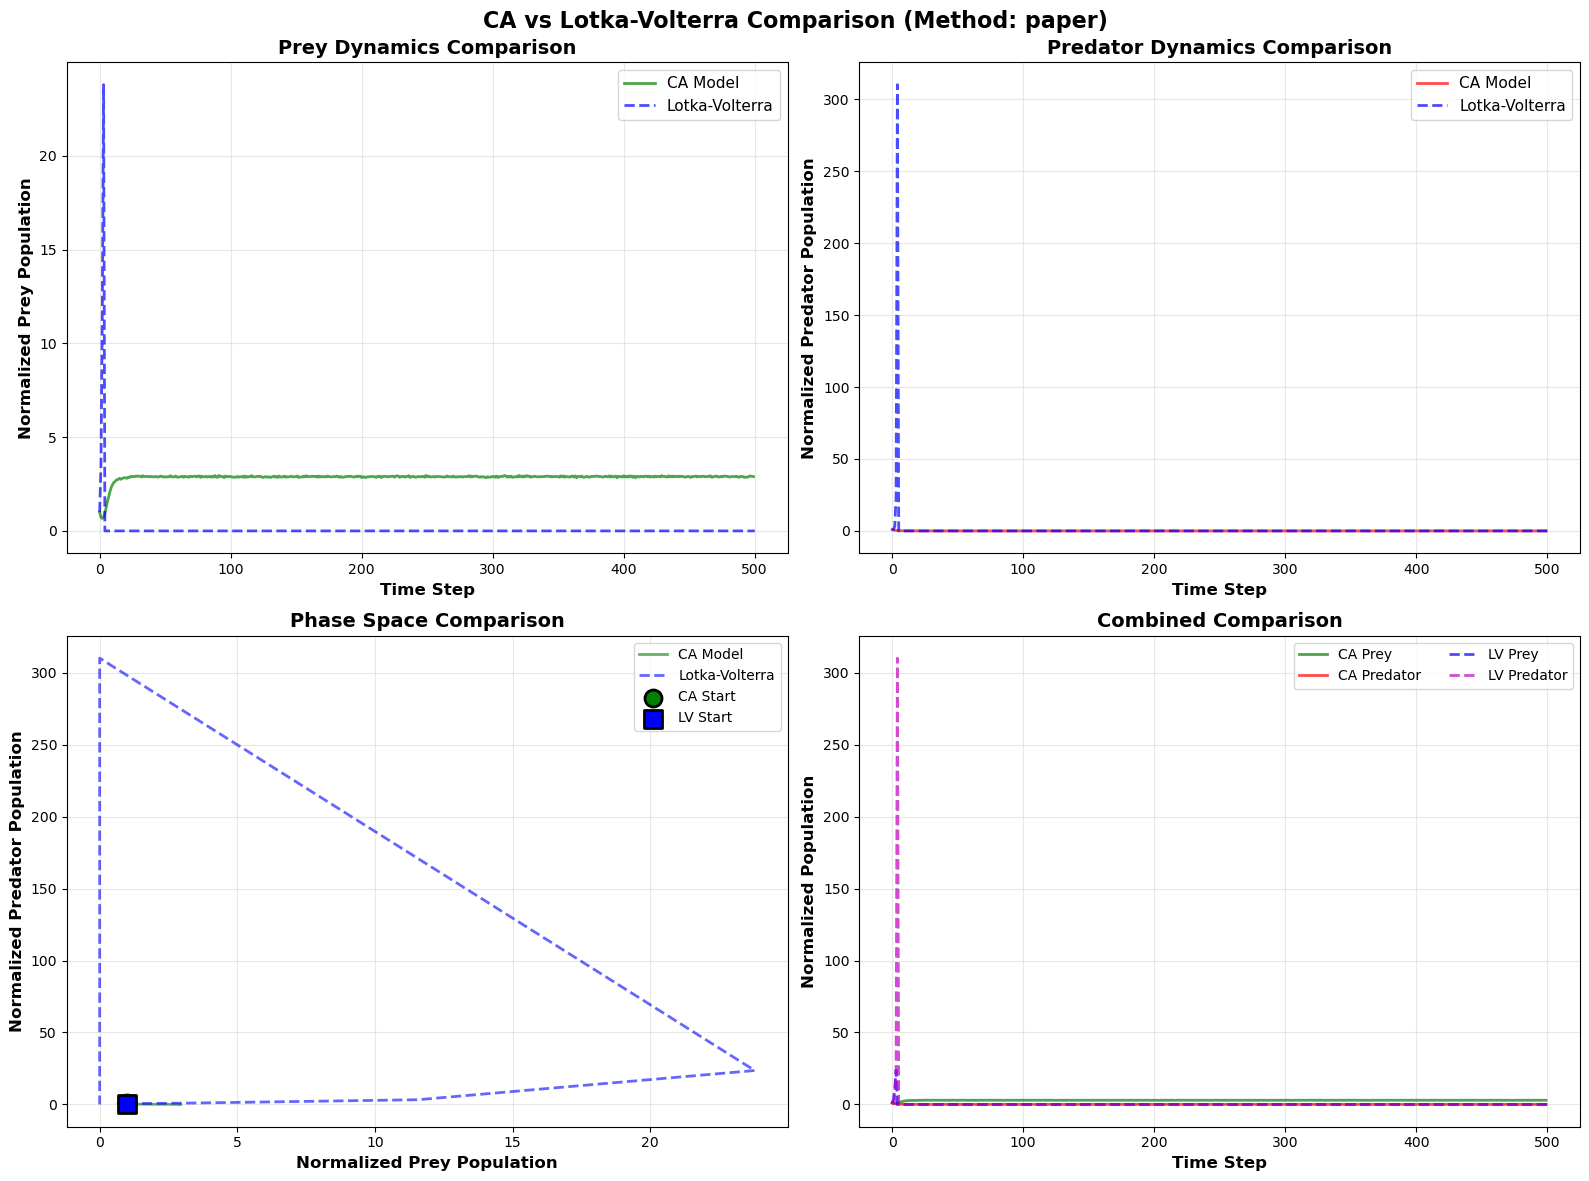


--- COMPARISON STATISTICS ---
Prey correlation: -0.6041
Predator correlation: 0.1875
Prey RMSE: 3.0890
Predator RMSE: 13.9037

⚠ Warning: LV model shows near-extinction!
  Consider using 'paper' method or adjusting CA parameters


In [13]:
# ============================================================================
# LOTKA-VOLTERRA DISCRETE TIME SYSTEM
# ============================================================================

@dataclass
class LotkaVolterraParams:
    """
    Parameters for discrete Lotka-Volterra equations.
    
    Based on Equation 1 from the paper:
    x1(t+1) = x1(t)[(1 + k1) - a11*x1(t)] - a12*x1(t)*x2(t)
    x2(t+1) = x2(t)[(1 + k2) - a22*x2(t)] + a21*x1(t)*x2(t)
    
    where:
    - x1 = prey population
    - x2 = predator population
    - k1 = prey growth rate
    - k2 = predator death rate (negative)
    - a11 = intraspecific competition (prey)
    - a22 = intraspecific competition (predator)
    - a12 = predation rate (effect on prey)
    - a21 = conversion efficiency (effect on predator)
    """
    k1: float  # Prey growth rate
    k2: float  # Predator growth/death rate
    a11: float  # Prey self-limitation
    a22: float  # Predator self-limitation
    a12: float  # Predation impact on prey
    a21: float  # Predation benefit to predator


class LotkaVolterraSystem:
    """
    Discrete time Lotka-Volterra predator-prey system.
    
    Implements the difference equations from Section 2 of the paper.
    """
    
    def __init__(self, params: LotkaVolterraParams, 
                 initial_prey: float, 
                 initial_predator: float):
        """
        Initialize the Lotka-Volterra system.
        
        Args:
            params: System parameters
            initial_prey: Initial prey population
            initial_predator: Initial predator population
        """
        self.params = params
        self.prey_history = [initial_prey]
        self.predator_history = [initial_predator]
        self.time_step = 0
    
    def step(self):
        """
        Execute one time step of the discrete Lotka-Volterra equations.
        """
        x1 = self.prey_history[-1]  # Current prey
        x2 = self.predator_history[-1]  # Current predator
        
        # Equation 1 from the paper
        x1_next = x1 * ((1 + self.params.k1) - self.params.a11 * x1) - \
                  self.params.a12 * x1 * x2
        
        x2_next = x2 * ((1 + self.params.k2) - self.params.a22 * x2) + \
                  self.params.a21 * x1 * x2
        
        # Ensure non-negative populations
        x1_next = max(0, x1_next)
        x2_next = max(0, x2_next)
        
        self.prey_history.append(x1_next)
        self.predator_history.append(x2_next)
        self.time_step += 1
    
    def run(self, num_steps: int):
        """
        Run the system for multiple time steps.
        
        Args:
            num_steps: Number of steps to simulate
        """
        for _ in range(num_steps):
            self.step()
    
    def get_current_state(self) -> Tuple[float, float]:
        """Get current prey and predator populations."""
        return self.prey_history[-1], self.predator_history[-1]


class LogisticEquation:
    """
    Single population logistic equation (special case).
    
    Used for testing prey-only or predator-only scenarios.
    Equation: x(t+1) = x(t) + k*x(t)*(1 - x(t)/L)
    """
    
    def __init__(self, k: float, L: float, initial_pop: float):
        """
        Initialize logistic equation.
        
        Args:
            k: Growth rate
            L: Carrying capacity
            initial_pop: Initial population
        """
        self.k = k
        self.L = L
        self.history = [initial_pop]
        self.time_step = 0
    
    def step(self):
        """Execute one time step."""
        x = self.history[-1]
        x_next = x + self.k * x * (1 - x / self.L)
        x_next = max(0, x_next)
        self.history.append(x_next)
        self.time_step += 1
    
    def run(self, num_steps: int):
        """Run for multiple steps."""
        for _ in range(num_steps):
            self.step()


# ============================================================================
# COMPARISON FUNCTIONS
# ============================================================================


def demonstrate_logistic_behaviors():
    """
    Demonstrate different behaviors of the logistic equation.
    
    Recreates Figure 1 from the paper showing different growth rate scenarios.
    """
    print("\n" + "="*70)
    print("DEMONSTRATING LOGISTIC EQUATION BEHAVIORS")
    print("="*70)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    scenarios = [
        {'k': -0.2, 'L': 100, 'x0': 50, 'title': '(a) -1 < k < 0\n(0 attracting, L repelling)'},
        {'k': 0.23, 'L': 20, 'x0': 5, 'title': '(b) 0 < k < 1\n(0 repelling, L attracting)'},
        {'k': 1.98, 'L': 20, 'x0': 5, 'title': '(c) 1 < k < 2\n(0 repelling, L attracting with oscillations)'},
        {'k': 2.6, 'L': 20, 'x0': 5, 'title': '(d) 2 < k < 3\n(0 and L repelling)'}
    ]
    
    for idx, (ax, scenario) in enumerate(zip(axes.flatten(), scenarios)):
        system = LogisticEquation(scenario['k'], scenario['L'], scenario['x0'])
        system.run(60)
        
        ax.plot(system.history, 'b-', linewidth=2)
        ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='x=0')
        ax.axhline(y=scenario['L'], color='g', linestyle='--', alpha=0.5, label=f'x=L={scenario["L"]}')
        ax.set_xlabel('Time', fontsize=11)
        ax.set_ylabel('Population', fontsize=11)
        ax.set_title(scenario['title'], fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Logistic Equation: Different Growth Rate Behaviors\n(Figure 1 from paper)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def demonstrate_lotka_volterra_behaviors():
    """
    Demonstrate oscillatory behavior in Lotka-Volterra system.
    
    Recreates Figure 2 from the paper.
    """
    print("\n" + "="*70)
    print("DEMONSTRATING LOTKA-VOLTERRA OSCILLATIONS")
    print("="*70)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Different parameter sets showing various behaviors
    scenarios = [
        {'k1': 2.8, 'k2': 0.5, 'a11': 0.01, 'a22': 0.01, 'a12': 0.5, 'a21': 0.5,
         'x1_0': 1.0, 'x2_0': 0.5, 'title': '(a,b) k1=2.8, k2=0.5, a12=a21=0.5'},
        {'k1': 2.8, 'k2': 0.5, 'a11': 0.01, 'a22': 0.01, 'a12': 0.7, 'a21': 0.7,
         'x1_0': 1.0, 'x2_0': 0.5, 'title': '(c,d) k1=2.8, k2=0.5, a12=a21=0.7'},
    ]
    
    for scenario_idx, scenario in enumerate(scenarios):
        params = LotkaVolterraParams(
            k1=scenario['k1'],
            k2=scenario['k2'],
            a11=scenario['a11'],
            a22=scenario['a22'],
            a12=scenario['a12'],
            a21=scenario['a21']
        )
        
        lv = LotkaVolterraSystem(params, scenario['x1_0'], scenario['x2_0'])
        lv.run(200)
        
        # Time series plot
        ax_ts = axes[scenario_idx, 0]
        ax_ts.plot(lv.prey_history, 'g-', linewidth=2, label='Prey')
        ax_ts.plot(lv.predator_history, 'r-', linewidth=2, label='Predator')
        ax_ts.set_xlabel('Time', fontsize=11)
        ax_ts.set_ylabel('Population', fontsize=11)
        ax_ts.set_title(f'{scenario["title"]}\nTime Series', fontsize=10, fontweight='bold')
        ax_ts.legend(fontsize=9)
        ax_ts.grid(True, alpha=0.3)
        
        # Phase space
        ax_phase = axes[scenario_idx, 1]
        ax_phase.plot(lv.prey_history, lv.predator_history, 'b-', linewidth=1.5, alpha=0.7)
        ax_phase.scatter(lv.prey_history[0], lv.predator_history[0], 
                        c='green', s=100, marker='o', label='Start', zorder=5)
        ax_phase.scatter(lv.prey_history[-1], lv.predator_history[-1], 
                        c='red', s=100, marker='s', label='End', zorder=5)
        ax_phase.set_xlabel('Prey', fontsize=11)
        ax_phase.set_ylabel('Predator', fontsize=11)
        ax_phase.set_title('Phase Space', fontsize=10, fontweight='bold')
        ax_phase.legend(fontsize=9)
        ax_phase.grid(True, alpha=0.3)
        
        # Zoomed phase space (last portion)
        ax_zoom = axes[scenario_idx, 2]
        zoom_start = len(lv.prey_history) // 2
        ax_zoom.plot(lv.prey_history[zoom_start:], lv.predator_history[zoom_start:], 
                    'b-', linewidth=2, alpha=0.7)
        ax_zoom.set_xlabel('Prey', fontsize=11)
        ax_zoom.set_ylabel('Predator', fontsize=11)
        ax_zoom.set_title('Phase Space (Last Half)', fontsize=10, fontweight='bold')
        ax_zoom.grid(True, alpha=0.3)
    
    plt.suptitle('Discrete Lotka-Volterra Oscillatory Behavior\n(Figure 2 from paper)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def calibrate_ca_to_lotka_volterra_improved(ca_config: 'SimulationConfig',
                                            num_steps: int = 200,
                                            method: str = 'manual') -> LotkaVolterraParams:
    """
    Improved calibration of Lotka-Volterra parameters to match CA behavior.
    
    Args:
        ca_config: CA configuration
        num_steps: Number of steps for calibration
        method: 'manual' for heuristic, 'optimize' for fitted parameters
        
    Returns:
        Calibrated LotkaVolterraParams
    """
    print("\n" + "="*70)
    print("CALIBRATING LOTKA-VOLTERRA TO MATCH CA")
    print("="*70)
    
    if method == 'manual':
        return _manual_calibration(ca_config)
    elif method == 'optimize':
        return _optimized_calibration(ca_config, num_steps)
    else:
        raise ValueError("method must be 'manual' or 'optimize'")


def _manual_calibration(ca_config: 'SimulationConfig') -> LotkaVolterraParams:
    """
    Manual/heuristic calibration based on biological interpretation.
    
    Key insight: The CA operates on absolute counts, but LV needs to be
    scaled to match the population densities.
    """
    grid_size = ca_config.grid_size[0] * ca_config.grid_size[1]
    
    # Scale populations to densities (fraction of grid occupied)
    prey_density = ca_config.initial_prey / grid_size
    pred_density = ca_config.initial_predator1 / grid_size
    
    print(f"\nGrid size: {grid_size}")
    print(f"Initial prey density: {prey_density:.4f}")
    print(f"Initial predator density: {pred_density:.4f}")
    
    # Prey growth rate k1
    # In CA: prey reproduce with probability bp in empty cells with prey neighbors
    # Effective growth ≈ bp * (fraction of neighbors that are prey) * (fraction empty)
    # For moderate densities: k1 ≈ bp * (1 - total_density)
    bp = ca_config.prey_params.birth_prob
    total_density = prey_density + pred_density
    k1 = bp * 2.0 * (1 - total_density)  # Scale factor ~2 for local interactions
    
    # Predator growth/death rate k2
    # In CA: predators die with probability dh
    # But they also reproduce after eating, so net effect is complex
    dh = ca_config.predator1_params.death_prob
    bh = ca_config.predator1_params.birth_prob
    # Net growth when no prey: -dh
    # Net growth when prey available: (bh * hunt_success) - dh
    k2 = -dh + (bh * ca_config.predator1_params.hunt_success_prob * prey_density)
    
    # Prey self-limitation (intraspecific competition)
    # This controls carrying capacity: K ≈ (1+k1)/a11
    # We want K to be around the grid capacity
    # So a11 ≈ (1+k1) / (desired_capacity)
    desired_prey_capacity = 0.6  # 60% of grid
    a11 = (1 + k1) / desired_prey_capacity if k1 > -1 else 0.001
    
    # Predator self-limitation
    # Predators limited by prey availability and space
    desired_pred_capacity = 0.3  # 30% of grid
    a22 = (1 + k2) / desired_pred_capacity if k2 > -1 else 0.001
    
    # Predation rate a12 (effect on prey)
    # In CA: prey dies if predator in neighborhood with probability dp
    # Need to scale by encounter rate
    dp = ca_config.predator1_params.hunt_success_prob
    # Expected encounters per time step ≈ pred_density * neighborhood_size
    # Von Neumann neighborhood = 4 cells
    encounter_prob = 4.0 / grid_size  # Very small for large grids
    a12 = dp * 10.0  # Scale up since LV uses continuous interactions
    
    # Conversion efficiency a21 (predator benefit from eating prey)
    # In CA: successful hunt leads to reproduction with probability bh
    bh = ca_config.predator1_params.birth_prob
    a21 = bh * dp * 5.0  # Scale factor for continuous vs discrete
    
    # Ensure stability: check Lotka-Volterra equilibrium exists
    # Equilibrium: x1* = (1+k2-a22*x2*)/a21, x2* = (1+k1-a11*x1*)/a12
    # For positive equilibrium: need k1 > 0 and a21*(1+k2) < a22*a12*(1+k1)
    
    params = LotkaVolterraParams(
        k1=k1,
        k2=k2,
        a11=a11,
        a22=a22,
        a12=a12,
        a21=a21
    )
    
    print(f"\nCalibrated Parameters (Manual Method):")
    print(f"  k1 (prey growth): {k1:.3f}")
    print(f"  k2 (predator growth): {k2:.3f}")
    print(f"  a11 (prey competition): {a11:.4f}")
    print(f"  a22 (predator competition): {a22:.4f}")
    print(f"  a12 (predation rate): {a12:.3f}")
    print(f"  a21 (conversion efficiency): {a21:.3f}")
    
    # Check for equilibrium
    if k1 > 0:
        x2_star = (1 + k1) / a12
        x1_star = (1 + k2) / a21 + (a22 * x2_star) / a21
        if x1_star > 0 and x2_star > 0:
            print(f"\nPredicted equilibrium:")
            print(f"  Prey: {x1_star:.3f}")
            print(f"  Predator: {x2_star:.3f}")
        else:
            print("\nWarning: No stable equilibrium predicted!")
    
    return params


def _optimized_calibration(ca_config: 'SimulationConfig', 
                          num_steps: int) -> LotkaVolterraParams:
    """
    Use optimization to fit LV parameters to CA trajectory.
    
    This runs a short CA simulation and fits LV parameters to match it.
    """
    print("\nRunning CA simulation for parameter fitting...")
    
    # Run CA
    ca = PredatorPreyCA(ca_config)
    ca.run(num_steps, verbose=False)
    
    # Get normalized trajectories
    initial_prey = ca.prey_history[0]
    initial_pred = ca.predator1_history[0]
    
    ca_prey_normalized = np.array(ca.prey_history) / initial_prey
    ca_pred_normalized = np.array(ca.predator1_history) / initial_pred
    
    print("Optimizing parameters to match CA trajectory...")
    
    def objective(params_array):
        """Objective function: minimize difference between LV and CA."""
        k1, k2, a11, a22, a12, a21 = params_array
        
        # Ensure positive parameters
        if a11 <= 0 or a22 <= 0 or a12 <= 0 or a21 <= 0:
            return 1e10
        
        try:
            lv_params = LotkaVolterraParams(k1, k2, a11, a22, a12, a21)
            lv = LotkaVolterraSystem(lv_params, 1.0, 1.0)  # Start normalized
            lv.run(num_steps)
            
            lv_prey = np.array(lv.prey_history)
            lv_pred = np.array(lv.predator_history)
            
            # Calculate error (mean squared difference)
            prey_error = np.mean((ca_prey_normalized - lv_prey)**2)
            pred_error = np.mean((ca_pred_normalized - lv_pred)**2)
            
            total_error = prey_error + pred_error
            
            return total_error
            
        except:
            return 1e10
    
    # Initial guess (from manual calibration)
    manual_params = _manual_calibration(ca_config)
    x0 = [manual_params.k1, manual_params.k2, manual_params.a11, 
          manual_params.a22, manual_params.a12, manual_params.a21]
    
    # Bounds for parameters
    bounds = [
        (-0.5, 5.0),    # k1: prey growth
        (-1.0, 2.0),    # k2: predator growth
        (0.001, 10.0),  # a11: prey competition
        (0.001, 10.0),  # a22: predator competition
        (0.001, 10.0),  # a12: predation rate
        (0.001, 10.0),  # a21: conversion efficiency
    ]
    
    result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds,
                     options={'maxiter': 100})
    
    k1, k2, a11, a22, a12, a21 = result.x
    
    params = LotkaVolterraParams(k1, k2, a11, a22, a12, a21)
    
    print(f"\nOptimized Parameters:")
    print(f"  k1 (prey growth): {k1:.3f}")
    print(f"  k2 (predator growth): {k2:.3f}")
    print(f"  a11 (prey competition): {a11:.4f}")
    print(f"  a22 (predator competition): {a22:.4f}")
    print(f"  a12 (predation rate): {a12:.3f}")
    print(f"  a21 (conversion efficiency): {a21:.3f}")
    print(f"  Final error: {result.fun:.6f}")
    
    return params


def use_paper_parameters() -> LotkaVolterraParams:
    """
    Use parameters similar to those shown in Figure 2 of the paper.
    
    Returns:
        LotkaVolterraParams matching paper's examples
    """
    print("\n" + "="*70)
    print("USING PARAMETERS FROM PAPER (Figure 2)")
    print("="*70)
    
    # From the paper: k1 = 2.8, k2 = 0.5, a12 = a21 = 0.5
    # These produce oscillations
    params = LotkaVolterraParams(
        k1=2.8,
        k2=0.5,
        a11=0.01,  # Small intraspecific competition
        a22=0.01,
        a12=0.5,
        a21=0.5
    )
    
    print(f"\nPaper Parameters:")
    print(f"  k1 (prey growth): {params.k1:.3f}")
    print(f"  k2 (predator growth): {params.k2:.3f}")
    print(f"  a11 (prey competition): {params.a11:.4f}")
    print(f"  a22 (predator competition): {params.a22:.4f}")
    print(f"  a12 (predation rate): {params.a12:.3f}")
    print(f"  a21 (conversion efficiency): {params.a21:.3f}")
    
    return params


def compare_ca_with_lotka_volterra_enhanced(ca: 'PredatorPreyCA',
                                           num_steps: int = 300,
                                           calibration_method: str = 'manual',
                                           save_path: Optional[str] = None):
    """
    Enhanced comparison with multiple calibration options.
    
    Args:
        ca: Cellular Automaton instance
        num_steps: Number of time steps
        calibration_method: 'manual', 'optimize', or 'paper'
        save_path: Path to save comparison plot
    """
    print("\n" + "="*70)
    print("COMPARING CA WITH LOTKA-VOLTERRA EQUATIONS")
    print(f"Calibration method: {calibration_method}")
    print("="*70)
    
    # Reset and run CA
    print("\nRunning Cellular Automaton simulation...")
    initial_config = ca.config
    ca.__init__(initial_config)
    ca.run(num_steps, verbose=False)
    
    # Get calibrated parameters
    if calibration_method == 'paper':
        lv_params = use_paper_parameters()
        # Scale initial conditions to match paper
        initial_prey = 1.0
        initial_predator = 0.5
    else:
        if calibration_method == 'manual':
            lv_params = calibrate_ca_to_lotka_volterra_improved(ca.config, num_steps, 'manual')
        else:
            lv_params = calibrate_ca_to_lotka_volterra_improved(ca.config, num_steps, 'optimize')
        
        # Use normalized initial conditions
        initial_prey = ca.prey_history[0]
        initial_predator = ca.predator1_history[0]
    
    # Run Lotka-Volterra
    print("\nRunning Lotka-Volterra model...")
    lv = LotkaVolterraSystem(lv_params, initial_prey, initial_predator)
    lv.run(num_steps)
    
    # Normalize for comparison
    ca_prey = np.array(ca.prey_history) / ca.prey_history[0]
    ca_pred = np.array(ca.predator1_history) / ca.predator1_history[0]
    
    if calibration_method == 'paper':
        lv_prey = np.array(lv.prey_history)
        lv_pred = np.array(lv.predator_history)
    else:
        lv_prey = np.array(lv.prey_history) / lv.prey_history[0]
        lv_pred = np.array(lv.predator_history) / lv.predator_history[0]
    
    # Create enhanced comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Time series comparison - Prey
    ax1 = axes[0, 0]
    ax1.plot(ca_prey, 'g-', linewidth=2, label='CA Model', alpha=0.7)
    ax1.plot(lv_prey, 'b--', linewidth=2, label='Lotka-Volterra', alpha=0.7)
    ax1.set_xlabel('Time Step', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Normalized Prey Population', fontsize=12, fontweight='bold')
    ax1.set_title('Prey Dynamics Comparison', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Time series comparison - Predator
    ax2 = axes[0, 1]
    ax2.plot(ca_pred, 'r-', linewidth=2, label='CA Model', alpha=0.7)
    ax2.plot(lv_pred, 'b--', linewidth=2, label='Lotka-Volterra', alpha=0.7)
    ax2.set_xlabel('Time Step', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Normalized Predator Population', fontsize=12, fontweight='bold')
    ax2.set_title('Predator Dynamics Comparison', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # Phase space comparison
    ax3 = axes[1, 0]
    ax3.plot(ca_prey, ca_pred, 'g-', linewidth=2, label='CA Model', alpha=0.6)
    ax3.plot(lv_prey, lv_pred, 'b--', linewidth=2, label='Lotka-Volterra', alpha=0.6)
    ax3.scatter(ca_prey[0], ca_pred[0], c='green', s=150, marker='o', 
               label='CA Start', zorder=5, edgecolors='black', linewidths=2)
    ax3.scatter(lv_prey[0], lv_pred[0], c='blue', s=150, marker='s', 
               label='LV Start', zorder=5, edgecolors='black', linewidths=2)
    ax3.set_xlabel('Normalized Prey Population', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Normalized Predator Population', fontsize=12, fontweight='bold')
    ax3.set_title('Phase Space Comparison', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Combined time series
    ax4 = axes[1, 1]
    ax4.plot(ca_prey, 'g-', linewidth=2, label='CA Prey', alpha=0.7)
    ax4.plot(ca_pred, 'r-', linewidth=2, label='CA Predator', alpha=0.7)
    ax4.plot(lv_prey, 'b--', linewidth=2, label='LV Prey', alpha=0.7)
    ax4.plot(lv_pred, 'm--', linewidth=2, label='LV Predator', alpha=0.7)
    ax4.set_xlabel('Time Step', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Normalized Population', fontsize=12, fontweight='bold')
    ax4.set_title('Combined Comparison', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=10, ncol=2)
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'CA vs Lotka-Volterra Comparison (Method: {calibration_method})', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Comparison plot saved to: {save_path}")
    
    plt.show()
    
    # Print statistics
    print("\n--- COMPARISON STATISTICS ---")
    
    # Calculate correlation (use min length in case of extinctions)
    min_len = min(len(ca_prey), len(lv_prey))
    prey_corr = np.corrcoef(ca_prey[:min_len], lv_prey[:min_len])[0, 1]
    pred_corr = np.corrcoef(ca_pred[:min_len], lv_pred[:min_len])[0, 1]
    
    print(f"Prey correlation: {prey_corr:.4f}")
    print(f"Predator correlation: {pred_corr:.4f}")
    
    # Calculate RMSE
    prey_rmse = np.sqrt(np.mean((ca_prey[:min_len] - lv_prey[:min_len])**2))
    pred_rmse = np.sqrt(np.mean((ca_pred[:min_len] - lv_pred[:min_len])**2))
    
    print(f"Prey RMSE: {prey_rmse:.4f}")
    print(f"Predator RMSE: {pred_rmse:.4f}")
    
    # Check for extinctions
    if lv_prey[-1] < 0.01 or lv_pred[-1] < 0.01:
        print("\n⚠ Warning: LV model shows near-extinction!")
        print("  Consider using 'paper' method or adjusting CA parameters")


# Update the main function
def run_example_simulation_with_lv_comparison():
    """
    Run simulation with improved Lotka-Volterra comparison.
    """
    print("=" * 70)
    print("PREDATOR-PREY CA WITH LOTKA-VOLTERRA COMPARISON")
    print("Based on Cattaneo, Dennunzio, and Farina (2006)")
    print("=" * 70)
    
    # Demonstrate theoretical models
    demonstrate_choice = input("\nDemonstrate Lotka-Volterra behaviors? (y/n) [default=n]: ").lower() or "n"
    
    if demonstrate_choice == 'y':
        demonstrate_logistic_behaviors()
        demonstrate_lotka_volterra_behaviors()
    
    # Configuration
    print("\n--- SIMULATION CONFIGURATION ---")
    grid_size = int(input("Grid size [default=100]: ") or "100")
    num_predators = 1  # Keep it simple for LV comparison
    
    initial_prey = int(input(f"Initial prey [default={grid_size**2 // 4}]: ") 
                      or str(grid_size**2 // 4))
    initial_pred1 = int(input(f"Initial predator 1 [default={grid_size**2 // 10}]: ") 
                       or str(grid_size**2 // 10))
    
    num_steps = int(input("Number of steps [default=300]: ") or "300")
    
    # Choose calibration method
    print("\n--- LOTKA-VOLTERRA CALIBRATION METHOD ---")
    print("1. Manual (heuristic parameter mapping)")
    print("2. Optimize (fit to CA trajectory)")
    print("3. Paper (use parameters from Figure 2)")
    method_choice = input("Choose method [1/2/3, default=1]: ") or "1"
    
    method_map = {'1': 'manual', '2': 'optimize', '3': 'paper'}
    calibration_method = method_map.get(method_choice, 'manual')
    
    # Create CA config
    config = SimulationConfig(
        grid_size=(grid_size, grid_size),
        num_predator_types=1,
        initial_prey=initial_prey,
        initial_predator1=initial_pred1,
        initial_predator2=0,
        prey_params=SpeciesParameters(birth_prob=0.6, death_prob=0.7),
        predator1_params=SpeciesParameters(birth_prob=0.3, death_prob=0.4, hunt_success_prob=0.7),
        predator2_params=SpeciesParameters(birth_prob=0.25, death_prob=0.45, hunt_success_prob=0.6),
        movement_radius=2,
        use_enhanced_model=True,
        enhancement_function="cosine"
    )
    
    # Create CA
    ca = PredatorPreyCA(config)
    
    # Run comparison
    compare_ca_with_lotka_volterra_enhanced(
        ca, 
        num_steps=num_steps,
        calibration_method=calibration_method,
        save_path=f"output/ca_vs_lv_{calibration_method}.png"
    )
    
    return ca


if __name__ == "__main__":
    ca = run_example_simulation_with_lv_comparison()